# Extracting regional values from Met Office Global meteorological data

## Process
This notebook runs you through how to extract spatial mean values from gridded data using shapefiles. The process includes:

1. Load the Shapefile for the regions we want to subset with.
2. Determine the full lat-lon extent of the shapefile.
3. Use lookup table shapefile_attributes.json to determine what geometry attributes we want to use for this shapefile.
4. Use daterange to generate filenames of NetCDFs we want to load
5. Load gridded data from NetCDF files into memory using Iris (using [lazy loading](https://scitools.org.uk/iris/docs/latest/userguide/real_and_lazy_data.html)).
6. Subset the data to only the extent of the shapefile, improving the processing time.
7. Loop through all the regions in the shapefile; subsetting, collapsing and generating a Pandas DataFrame for each region.
8. Each DataFrame is saved to CSV in a temporary location.
9. Collate all the region DataFrames into one DataFrame and save out to CSV
10. Delete the temporary files.

## Method
This process uses the polygon of a region (from the shapefile) to subset the gridded data by getting the **latitude-longitude bounding box** of the polygon, as described in this diagram:

<img src="images/coarse_spatial_mean_gridded.png" alt="Lat-Lon bounding box using polygon" style="height: 400px;"/> 

Each grid cell (small latitude-longitude box) contains a single value for a meteorological variable. The single value of that variable for the whole region/polygon is the mean of all the grid cell values in the bounding box i.e. lat-lon spatial mean.

For example, here we have air temperature values in a bounding box that covers the a polygon. The temperature value for the region is the mean value of the temperatures in the boundind box - 20.9°C.

<img src="images/spatial_mean_example.png" alt="The mean value for the temperature is 20.9°C" style="height: 400px;"/> 

#### Time
Of course we have ignored the time axis in this example, which is present in the gridded data but is handled for us by the Iris library as just another dimension. In this notebook we use daily data and will simply store the date for each value in the final tabular data.

#### Improvements
This process could be more accurate by only using the grid cells which actually overlap with the polygon and by weighting the grid cells according to how much of their area is within the polygon. Improvements like these are coming.

## Setup

In [1]:
#Data
import iris
import cartopy.io.shapereader as shpreader
import pandas as pd
import cftime

#Plotting
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline

#System
import os
import sys
import glob

#Met Office utils
import shape_utils as shape

#Supress warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Load shapefile containing region polygons

In [7]:
#Define shapefile path
shapefile = 'US_COUNTY_POP.shx'

In [7]:
#Load the shapefile
shape_reader = shpreader.Reader(shapefile)

In [8]:
#How many regions are included?
len([record for record in shape_reader.records()])

3142

In [9]:
#Let's take a look at one
next(shape_reader.records())

<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x7f017b14cfd0>, {'OBJECTID': 1, 'NAME': 'Autauga', 'STATE_NAME': 'Alabama', 'STATE_FIPS': '01', 'CNTY_FIPS': '001', 'FIPS': '01001', 'POPULATION': 56903, 'POP_SQMI': 94.2, 'POP2010': 54571, 'POP10_SQMI': 90.3, 'WHITE': 42855, 'BLACK': 9643, 'AMERI_ES': 232, 'ASIAN': 474, 'HAWN_PI': 32, 'HISPANIC': 1310, 'OTHER': 466, 'MULT_RACE': 869, 'MALES': 26569, 'FEMALES': 28002, 'AGE_UNDER5': 3579, 'AGE_5_9': 3991, 'AGE_10_14': 4290, 'AGE_15_19': 4290, 'AGE_20_24': 3080, 'AGE_25_34': 6487, 'AGE_35_44': 8243, 'AGE_45_54': 8205, 'AGE_55_64': 5860, 'AGE_65_74': 4013, 'AGE_75_84': 1982, 'AGE_85_UP': 551, 'MED_AGE': 36.9, 'MED_AGE_M': 35.9, 'MED_AGE_F': 37.8, 'HOUSEHOLDS': 20221, 'AVE_HH_SZ': 2.68, 'HSEHLD_1_M': 2012, 'HSEHLD_1_F': 2429, 'MARHH_CHD': 5522, 'MARHH_NO_C': 5845, 'MHH_CHILD': 558, 'FHH_CHILD': 1821, 'FAMILIES': 15064, 'AVE_FAM_SZ': 3.13, 'HSE_UNITS': 22135, 'VACANT': 1914, 'OWNER_OCC': 15248, 'RENTER_OCC': 4973, 'NO_FARMS17':

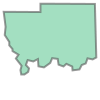

In [10]:
next(shape_reader.geometries())

## 2. Determine the full lat-lon extent of the shapefile

First we need some functions to help us

In [1]:
def get_shapefile_extent(shape_reader, buffer=0, **kwargs):
    '''
    Get the extent (x1, x2, y1, y2) of the union of all the polygons
    in a shapefile reader object, with an optional buffer added on.
    
    Arguments:
        shape_reader (cartopy.io.shapereader): Shapefile reader object
        buffer (num): optional buffer to add to the extent of the shapefile
        **kwargs: Keyword arguments for shape_utils.Shape class
    
    Returns:
        extent (tuple): Extent float values in format (x1, x2, y1, y2)
    '''
    #Get the geometries and records from shapefile_reader
    geos = [geo for geo in shape_reader.geometries()]
    recs = [rec for rec in shape_reader.records()]
    
    #Cycle through all the geometries in geos,
    #appending Shape object to ShapeList, if shape is valid
    shplist = shape.ShapeList([])
    for i in range(len(geos)):
        shp = shape.Shape(geos[i], recs[i].attributes, **kwargs) 
        if shp.is_valid:
            shplist.append(shp)
    
    #Get extent of union of all geometries
    wsen = shplist.unary_union().data.bounds
    
    #Rearrange extent from (x1, y1, x2, y2) to (x1, x2, y1, y2), adding buffer
    extent = (wsen[0]-buffer, wsen[2]+buffer, wsen[1]-buffer, wsen[3]+buffer)
    
    return extent

In [14]:
def plot_extent(extent):
    '''
    Use Matplotlib to plot the given extent on a map of the world, 
    in Plate Carree projection, with coastlines and country boundaries.
    
    Arguments:
        extent (tuple): Float values for lat-lon coordinates in (x1, x2, y1, y2) format
    
    Returns: 
        Displays plot
    '''
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(color='b')
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(extent)
    plt.show()

In [ ]:
#Get the extent of the shapefile, with a buffer of 1 degree
SHAPE_EXTENT = get_shapefile_extent(shape_reader)
SHAPE_EXTENT

In [ ]:
#Plot it to check that it looks how we expect it
plot_extent(SHAPE_EXTENT)

## 3. 

In [11]:
#We will use a list of the region IDs to loop through later
region_ids = [record.attributes['OBJECTID'] for record in shape_reader.records()]

In [13]:
print(region_ids[0], region_ids[-1])

1 3142


In [14]:
#Helper function to get the record from the reader
def get_region_record(target, shapefile=shape_reader, attribute='OBJECTID'):
    '''
    Get the geometries for the specified target.
    
    '''
    result = None
    for record in shapefile.records():
        location = record.attributes[attribute]
        if location == target:
            result = record
            break
    if result is None:
        emsg = f'Could not find region with {attribute} "{target}".'
        raise ValueError(emsg)
    return result

In [33]:
#Create a random ID generator
from random import randint
def rand_id(ids=region_ids): 
    return randint(ids[0], ids[-1])

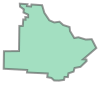

In [36]:
#Get a random geometry to check it's all working as expected
get_region_record(shape_reader, rand_id()).geometry

### 1. Load Met Office Global Data

The files for each variable are contained in a separate folder.

In [4]:
#List all the filepaths and store in a dict with each variable as a key
folder = '/data/covid19-ancillary-data/latest/mo_data_global_daily/'
filepaths = {path: glob.glob(os.path.join(folder, path, '*.nc')) for path in os.listdir(folder)}
variables = list(filepaths.keys())

print(variables)
print(f'Number of files for each variable: {len(filepaths[variables[0]])}')

['precip_max', 'precip_mean', 'sh_max', 'sh_mean', 'sh_min', 'sw_max', 'sw_mean', 't1o5m_max', 't1o5m_mean', 't1o5m_min']
Number of files for each variable: 103


In [12]:
%%time
#Run through all the variables and append the loaded cubes to a CubeList
cubes = iris.cube.CubeList([])

for var in variables:
    cubes.extend(iris.load(filepaths[var]))
    
print(cubes)

0: m01s01i202 / (1)                    (time: 103; latitude: 1920; longitude: 2560)
CPU times: user 7.54 s, sys: 779 ms, total: 8.32 s
Wall time: 10.8 s


## 2. Subset global data to the country we want

In [4]:
#Subset the cubes to just the USA
us_latlon = ((18, 75), (-179, -65))
us_cubes = iris.cube.CubeList([cube.intersection(latitude=us_latlon[0], longitude=us_latlon[1]) for cube in cubes])
print(us_cubes)

0: specific_humidity / (1)             (time: 91; latitude: 608; longitude: 811)
1: specific_humidity / (1)             (time: 91; latitude: 608; longitude: 811)
2: specific_humidity / (1)             (time: 91; latitude: 608; longitude: 811)
3: m01s01i202 / (1)                    (time: 91; latitude: 608; longitude: 811)
4: m01s01i202 / (1)                    (time: 91; latitude: 608; longitude: 811)
5: air_temperature / (K)               (time: 91; latitude: 608; longitude: 811)
6: air_temperature / (K)               (time: 91; latitude: 608; longitude: 811)
7: air_temperature / (K)               (time: 91; latitude: 608; longitude: 811)


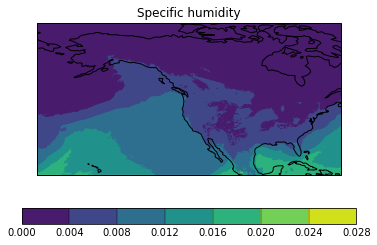

In [5]:
#Plot the subset to check that we have the right area
qplt.contourf(us_cubes[0][0])
plt.gca().coastlines()

In [6]:
#Extract the coordinate reference system from one of the cubes. We will use this later.
CRS = us_cubes[0].coord_system()
CRS

GeogCS(6371229.0)

## 4. Define the functions to be used in the pipeline.

In [8]:
def parse_data_name(cube):
    name = cube.name()
    method = cube.cell_methods[0].method.replace('imum', '')
    units = cube.units
    
    if name == 'm01s01i202':
        name = 'short_wave_radiation'
        units = 'W/m2'
    
    return f'{name}_{method} ({units})'

def get_date(dt):
    if isinstance(dt, cftime.real_datetime):
        date = dt.date()
    else:
        try:
            date = datetime.datetime(dt.year, dt.month, dt.day).date()
        except e:
            raise Exception(e)
    return date

In [23]:
def extract(location, cubes=us_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
#     cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    return cut_cubes

In [47]:
def extract_collapse_df(location, cubes=us_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
    cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    time = cubes_col[0].coord('time')
    length = len(time.points)
    data = {'objectid': [location]*length,
            'fips': [region.attributes['FIPS']]*length,
            'county_name': [region.attributes['NAME']]*length,
            'state_name': [region.attributes['STATE_NAME']]*length,
            'date': [get_date(cell.point) for cell in time.cells()]}
    data.update({parse_data_name(cube): cube.data for cube in cubes_col})
    
    df = pd.DataFrame(data, columns=COL_ORDER)

    return df

1079
0: specific_humidity / (1)             (time: 91; latitude: 4; longitude: 5)
1: specific_humidity / (1)             (time: 91; latitude: 4; longitude: 5)
2: specific_humidity / (1)             (time: 91; latitude: 4; longitude: 5)
3: m01s01i202 / (1)                    (time: 91; latitude: 4; longitude: 5)
4: m01s01i202 / (1)                    (time: 91; latitude: 4; longitude: 5)
5: air_temperature / (K)               (time: 91; latitude: 4; longitude: 5)
6: air_temperature / (K)               (time: 91; latitude: 4; longitude: 5)
7: air_temperature / (K)               (time: 91; latitude: 4; longitude: 5)


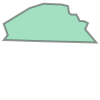

In [41]:
id_ = rand_id()
print(id_)
print(extract(id_, us_cubes, attribute='OBJECTID'))
display(get_region_record(shape_reader, id_, 'OBJECTID').geometry)

In [56]:
df_ex = extract_collapse_df(id_)
df_ex

,objectid,fips,county_name,state_name,date,air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1)
0,1079,21171,Monroe,Kentucky,2020-01-01,281.375000,277.219421,272.959381,453.940613,109.241623,0.003918,0.003385,0.002820
1,1079,21171,Monroe,Kentucky,2020-01-02,283.477356,279.532257,277.162506,61.387501,9.829915,0.007825,0.004788,0.003198
2,1079,21171,Monroe,Kentucky,2020-01-03,285.899231,284.045349,282.873444,62.741405,10.445475,0.009155,0.008184,0.007422
3,1079,21171,Monroe,Kentucky,2020-01-04,285.746094,280.198669,275.383606,261.553894,47.274773,0.009070,0.005971,0.003528
4,1079,21171,Monroe,Kentucky,2020-01-05,282.268738,276.644897,273.813293,455.005463,107.146484,0.004089,0.003561,0.003369
...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1079,21171,Monroe,Kentucky,2020-03-27,298.362488,293.496033,289.745300,616.667969,170.149017,0.014148,0.011031,0.009119
87,1079,21171,Monroe,Kentucky,2020-03-28,297.828125,294.396423,291.196106,589.668762,176.388000,0.013782,0.012765,0.011829
88,1079,21171,Monroe,Kentucky,2020-03-29,295.215637,292.526764,289.711731,739.301575,225.247589,0.013123,0.009711,0.006055
89,1079,21171,Monroe,Kentucky,2020-03-30,290.037506,286.366669,281.484375,706.430481,166.527740,0.006848,0.005685,0.004846


## 5. Loop through all the regions in the shapefile; subsetting, collapsing and saving out to a CSV file for each region.

In [44]:
#Set the order of the columns in the dataframes we will create
col0 = ['objectid', 'fips', 'county_name', 'state_name', 'date']
col1 = [parse_data_name(cube) for cube in us_cubes]
COL_ORDER = tuple(col0 + sorted([c for c in col1 if c not in col0]))
COL_ORDER

('objectid',
 'fips',
 'county_name',
 'state_name',
 'date',
 'air_temperature_max (K)',
 'air_temperature_mean (K)',
 'air_temperature_min (K)',
 'short_wave_radiation_max (W/m2)',
 'short_wave_radiation_mean (W/m2)',
 'specific_humidity_max (1)',
 'specific_humidity_mean (1)',
 'specific_humidity_min (1)')

In [52]:
#Let's look at the cubes we are going to 
print(us_cubes)

0: specific_humidity / (1)             (time: 91; latitude: 608; longitude: 811)
1: specific_humidity / (1)             (time: 91; latitude: 608; longitude: 811)
2: specific_humidity / (1)             (time: 91; latitude: 608; longitude: 811)
3: m01s01i202 / (1)                    (time: 91; latitude: 608; longitude: 811)
4: m01s01i202 / (1)                    (time: 91; latitude: 608; longitude: 811)
5: air_temperature / (K)               (time: 91; latitude: 608; longitude: 811)
6: air_temperature / (K)               (time: 91; latitude: 608; longitude: 811)
7: air_temperature / (K)               (time: 91; latitude: 608; longitude: 811)


In [53]:
#For now let's assume we haven't written any files, so we will loop through all the region IDs
unwritten = region_ids

In [ ]:
%%time
#This will loop through all the region IDs, executing extract_collapse_df for each region and saving it to a CSV file
#Any errors will be caught and printed, but the loop will continue onto the next ID
#Note that we cannot write to covid19-ancillary-data, so will have to write to /data/share/
start = len(csvs)
stop = len(region_ids)
for location in unwritten[start:]:
    try:
        df = extract_collapse_df(location)
        fname = df['fips'][0]
        county = df['county_name'][0]
        state = df['state_name'][0]
        df.to_csv(f'/data/share/us_data/us_{fname}_daily_data_2020jan-mar.csv', index=False)
        print(f'  [{location}] {fname}, {county}, {state}: Success')
    except Exception as e:
        print(f'x [{location}] {fname}, {county}, {state}: Error \n  x  {e}')

## 6. Load all the region CSVs, collate into one large DataFrame and save out to CSV.

In [ ]:
#List all the csvs in /data/share/us_data/
csvs = glob.glob('/data/share/us_data/*.csv')
len(csvs)

In [ ]:
%%time
#Now load all the CSVs for each region and combine into one large dataframe
df = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)
df

In [ ]:
#And save to a CSV
fname_write = '/data/share/us_daily_precipdata_2020jan-mar_v01.csv'
Mdf.to_csv(fname_write, index=False)

In [ ]:
#We can read it back in to check that it wrote correctly
pd.read_csv(fname_write)